In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=18, walltime='00:40:00')
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.29:34631 Dashboard: http://10.148.1.29:8787/status,Cluster Workers: 10 Cores: 280 Memory: 1.20 TB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_bandpass = xr.open_zarr(out_dir_zarr+'U_bandpass_filter_rechunk1.zarr')
ds_V_bandpass = xr.open_zarr(out_dir_zarr+'V_bandpass_filter_rechunk1.zarr')
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk1.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk1.zarr')

ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_U_lowpass,ds_V_lowpass,grid])
print(ds_filter)

<xarray.Dataset>
Dimensions:            (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC                (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dyG                (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * lat                (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 ... -14.4 -14.38
    rAw                (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * time               (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
    dxG                (lat_g, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dyC                (lat_g, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * lat_g              (lat_g) float64 47.4 47.41 47.42 ... 49.96 49.97 49.98
  * lon           

In [6]:
gridx = xgcm.Grid(grid, coords={'X':{'center':'lon', 'left':'lon_g'},
                                     'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center


# 2. Calculate $\Pi_{\omega}$

## horizontal terms

In [7]:
# low-pass filtered UV
dU_dx = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')

dU_dy_1 = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
dU_dy = gridx.interp(dU_dy_2, 'Y')

dV_dx_1 = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dV_dx = gridx.interp(dV_dx_2, 'Y')

dV_dy = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')


# bandpass filtered uv
du_dx = gridx.diff(ds_filter['U_bandpass_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')

du_dy_1 = gridx.diff(ds_filter['U_bandpass_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
du_dy_2 = gridx.interp(du_dy_1, 'X')
du_dy = gridx.interp(du_dy_2, 'Y')

dv_dx_1 = gridx.diff(ds_filter['V_bandpass_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dv_dx_2 = gridx.interp(dv_dx_1, 'X')
dv_dx = gridx.interp(dv_dx_2, 'Y')

dv_dy = gridx.diff(ds_filter['V_bandpass_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')


# (lat,lon)
u = gridx.interp(ds_filter.U_bandpass_filter, 'X')
v = gridx.interp(ds_filter.V_bandpass_filter, 'Y')
U = gridx.interp(ds_filter.U_low_filter, 'X')
V = gridx.interp(ds_filter.V_low_filter, 'Y')

## $\Pi_{\omega}$ (14_2)

In [8]:
Pi_h = -(u*u*dU_dx + u*v*dU_dy + u*v*dV_dx + v*v*dV_dy)

chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Pi_h = Pi_h.chunk(chunks)
Pi_h = np.real(Pi_h).rename('Pi_h')
Pi_h = Pi_h.to_dataset()
print(Pi_h)
file_out = out_dir_zarr+'/Pi_horizontal_rechunk.zarr'
%time Pi_h.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float32 -18.03125 -18.010416 ... -14.385417 -14.364583
Data variables:
    Pi_h     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


Worker tcp://10.148.0.33:37963 restart in Job 6816165. This can be due to memory issue.


KeyboardInterrupt: 

Worker tcp://10.148.0.197:34008 restart in Job 6816161. This can be due to memory issue.


## $\Pi_{\omega}$ (14_3)

In [12]:
Pi_h_extra_14 = -(u*U*dU_dx + u*V*dU_dy + v*U*dV_dx + v*V*dV_dy)

chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Pi_h_extra_14= Pi_h_extra_14.chunk(chunks)
Pi_h_extra_14 = np.real(Pi_h_extra_14).rename('Pi_h_extra_14')
Pi_h_extra_14 = Pi_h_extra_14.to_dataset()
print(Pi_h_extra_14)
file_out = out_dir_zarr+'/Pi_horizontal_extra_14_rechunk.zarr'
%time Pi_h_extra_14.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:        (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time           (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
  * depth          (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat            (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon            (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
Data variables:
    Pi_h_extra_14  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>
CPU times: user 46.1 s, sys: 3.67 s, total: 49.8 s
Wall time: 5min 37s


## $\Pi_{\omega}$ (14_1) the first divergence term

In [9]:
u_tot = ds_filter['U_low_filter'] + ds_filter['U_bandpass_filter']
v_tot = ds_filter['V_low_filter'] + ds_filter['V_bandpass_filter']

U_term = u_tot*ds_filter['U_bandpass_filter']*ds_filter['U_low_filter']
V_term = v_tot*ds_filter['V_bandpass_filter']*ds_filter['V_low_filter']

U_term_tmean = U_term.mean(['time'])
V_term_tmean = V_term.mean(['time'])

du_dx_14 = gridx.diff(U_term_tmean, 'X')/gridx.interp(ds_filter.dxG, 'Y')
dv_dy_14 = gridx.diff(V_term_tmean, 'Y')/gridx.interp(ds_filter.dyG, 'X')

Pi_h_14_first_tmean = du_dx_14 + dv_dy_14
Pi_h_14_first_tmean

<xarray.DataArray (depth: 52, lat: 201, lon: 177)>
dask.array<add, shape=(52, 201, 177), dtype=float32, chunksize=(1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [10]:
chunks = {'lat': 201, 'lon': 177, 'depth':1}
Pi_h_14_first_tmean = Pi_h_14_first_tmean.chunk(chunks)
Pi_h_14_first_tmean = np.real(Pi_h_14_first_tmean).rename('Pi_h_14_first_tmean')
Pi_h_14_first_tmean = Pi_h_14_first_tmean.to_dataset()
print(Pi_h_14_first_tmean)
file_out = out_dir_zarr+'/Pi_h_14_first_tmean.zarr'
%time Pi_h_14_first_tmean.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:              (depth: 52, lat: 201, lon: 177)
Coordinates:
  * depth                (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
  * lat                  (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                  (lon) float64 -18.03 -18.01 -17.99 ... -14.39 -14.36
Data variables:
    Pi_h_14_first_tmean  (depth, lat, lon) float32 dask.array<chunksize=(1, 201, 177), meta=np.ndarray>
CPU times: user 13.6 s, sys: 1.04 s, total: 14.6 s
Wall time: 2min 50s


In [7]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
Pi_h_14_first_tmean = xr.open_zarr(out_dir_zarr+'Pi_h_14_first_tmean.zarr')
print(Pi_h_14_first_tmean)

<xarray.Dataset>
Dimensions:              (depth: 52, lat: 201, lon: 177)
Coordinates:
  * depth                (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
  * lat                  (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                  (lon) float64 -18.03 -18.01 -17.99 ... -14.39 -14.36
Data variables:
    Pi_h_14_first_tmean  (depth, lat, lon) float32 dask.array<chunksize=(1, 201, 177), meta=np.ndarray>


(-3e-09, 3e-09)

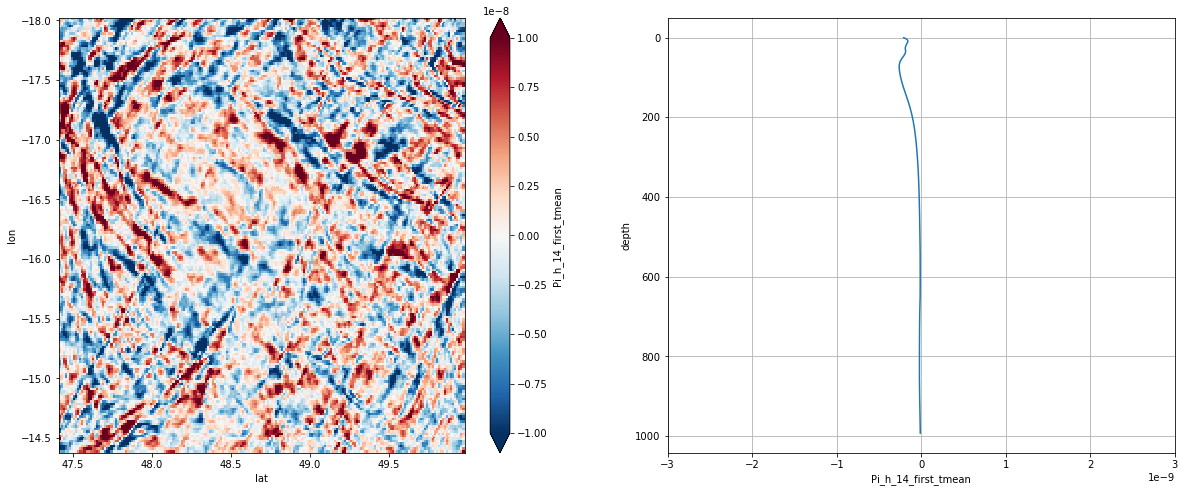

In [8]:
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(121)
Pi_h_14_first_tmean.Pi_h_14_first_tmean.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth']).plot(x='lat', y='lon',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)

ax = plt.subplot(122)
Pi_h_14_first_tmean.Pi_h_14_first_tmean.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-3e-9,3e-9])

## $\Pi_{\omega}$ (11)

In [9]:
Pi_h_11 = (U*U*du_dx + U*V*du_dy + U*V*dv_dx + V*V*dv_dy) + (u*U*du_dx + u*V*du_dy + v*U*dv_dx + v*V*dv_dy)

chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Pi_h_11 = Pi_h_11.chunk(chunks)
Pi_h_11 = np.real(Pi_h_11).rename('Pi_h_11')
Pi_h_11 = Pi_h_11.to_dataset()
print(Pi_h_11)
file_out = out_dir_zarr+'/Pi_horizontal_11_rechunk.zarr'
%time Pi_h_11.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:        (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time           (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
  * depth          (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat            (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon            (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
Data variables:
    Pi_h_11_term1  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>
CPU times: user 43.5 s, sys: 2.77 s, total: 46.3 s
Wall time: 5min 20s


# 3. Read and plot PI_omega (h) results

In [5]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

In [6]:
Pi_h = xr.open_zarr(out_dir_zarr+'Pi_horizontal_rechunk.zarr')
print(Pi_h)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    Pi_h     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


In [7]:
Pi_h_extra_14 = xr.open_zarr(out_dir_zarr+'Pi_horizontal_extra_14_rechunk.zarr')
print(Pi_h_extra_14)

<xarray.Dataset>
Dimensions:        (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth          (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat            (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon            (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time           (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
Data variables:
    Pi_h_extra_14  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


In [8]:
Pi_h_11 = xr.open_zarr(out_dir_zarr+'Pi_horizontal_11_rechunk.zarr')
print(Pi_h_11)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    Pi_h_11  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


## $\Pi_{\omega}$(original) vs. $\Pi_{\omega}$(14)

In [9]:
Pi_h_14 = Pi_h.Pi_h + Pi_h_extra_14.Pi_h_extra_14
Pi_h_14

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<add, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

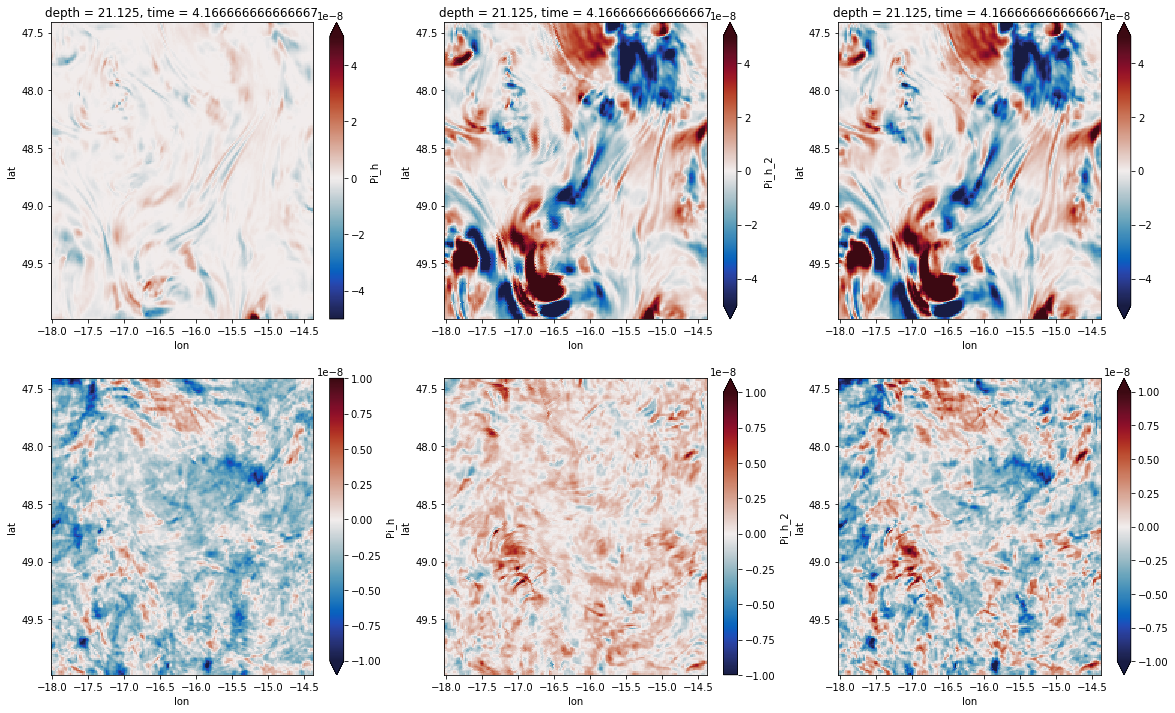

In [62]:
fig = plt.figure(figsize=(20,12))

plt.subplot(231)
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10,time=100).plot(x='lon', y='lat',cmap=cm.balance, vmin=-5e-8,vmax=5e-8,yincrease=False)

plt.subplot(232)
Pi_h_extra_14.Pi_h_extra_14.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10,time=100).plot(x='lon', y='lat',cmap=cm.balance, vmin=-5e-8,vmax=5e-8,yincrease=False)

plt.subplot(233)
Pi_h_14.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10,time=100).plot(x='lon', y='lat',cmap=cm.balance, vmin=-5e-8,vmax=5e-8,yincrease=False)

plt.subplot(234)
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8,yincrease=False)

plt.subplot(235)
Pi_h_extra_14.Pi_h_extra_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8,yincrease=False)

plt.subplot(236)
Pi_h_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8,yincrease=False)

In [ ]:
ax = plt.subplot(2,2,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'--',color='dimgrey')
ax.set_title('LLC4320',fontsize=font_size)


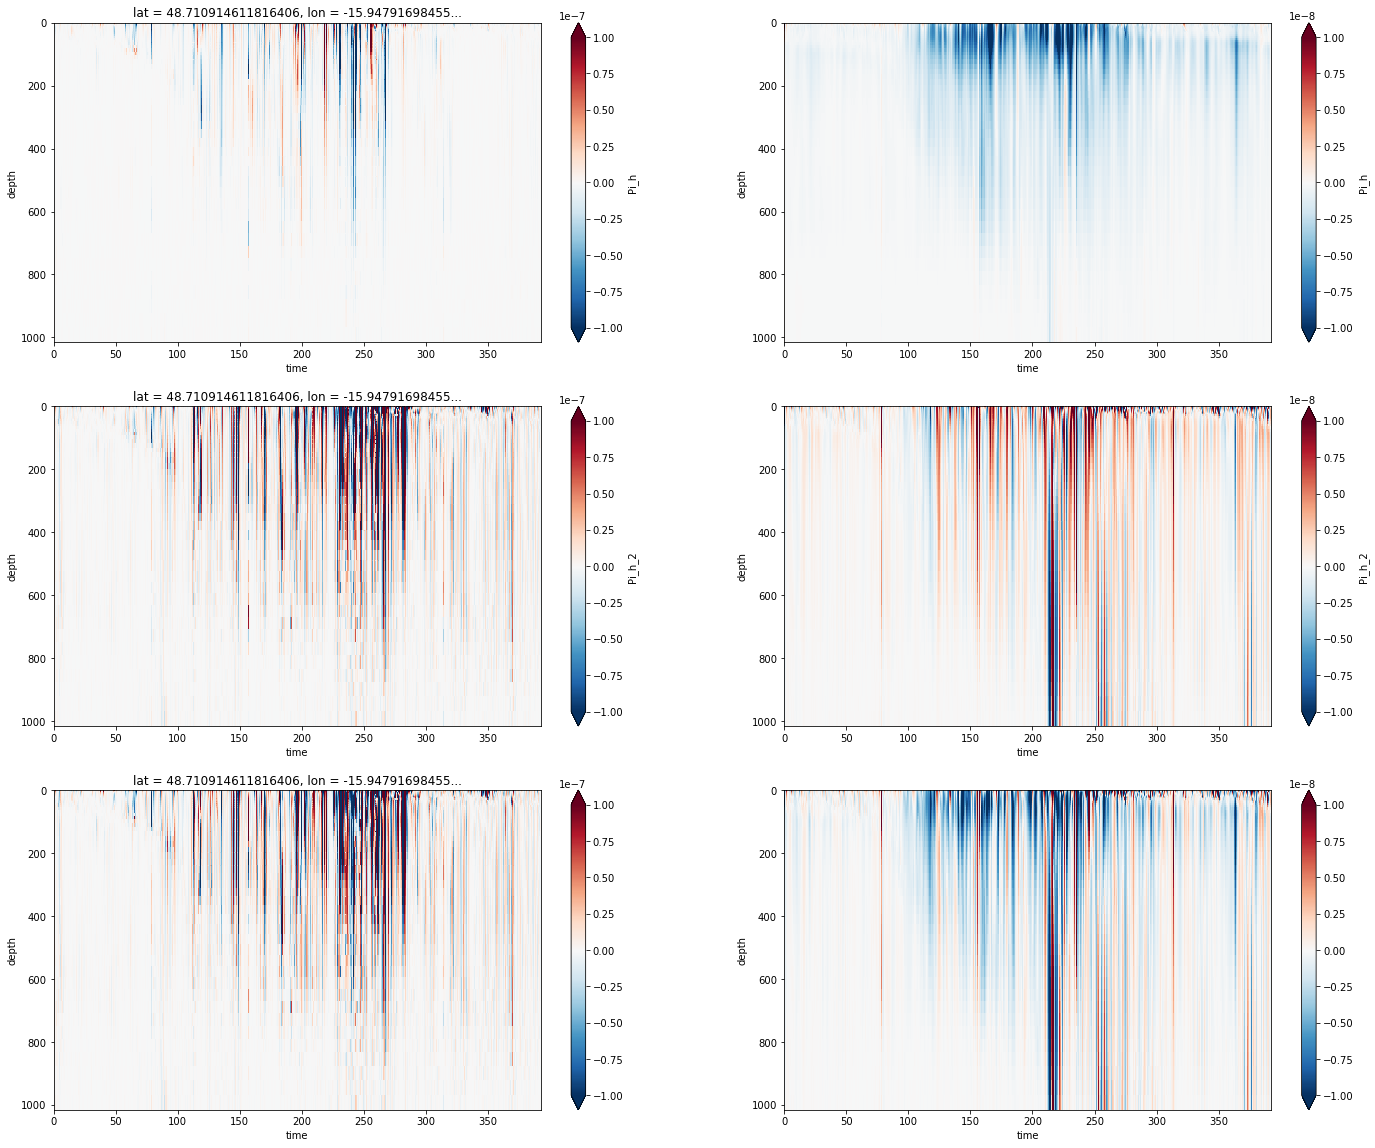

In [20]:
fig = plt.figure(figsize=(24,20))

plt.subplot(321)
Pi_h.Pi_h.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False)

plt.subplot(323)
Pi_h_extra_14.Pi_h_extra_14.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False)

plt.subplot(325)
Pi_h_14.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False)

plt.subplot(322)
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)

plt.subplot(324)
Pi_h_extra_14.Pi_h_extra_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)

plt.subplot(326)
Pi_h_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)

## The whole domain

In [32]:
Pi_h_smean = Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
Pi_h_cum = xr.DataArray.cumsum(Pi_h_smean, dim='time')

Pi_h_extra_14_smean = Pi_h_extra_14.Pi_h_extra_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
Pi_h_extra_14_cum = xr.DataArray.cumsum(Pi_h_extra_14_smean, dim='time')

Pi_h_14_smean = Pi_h_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
Pi_h_14_cum = xr.DataArray.cumsum(Pi_h_14_smean, dim='time')

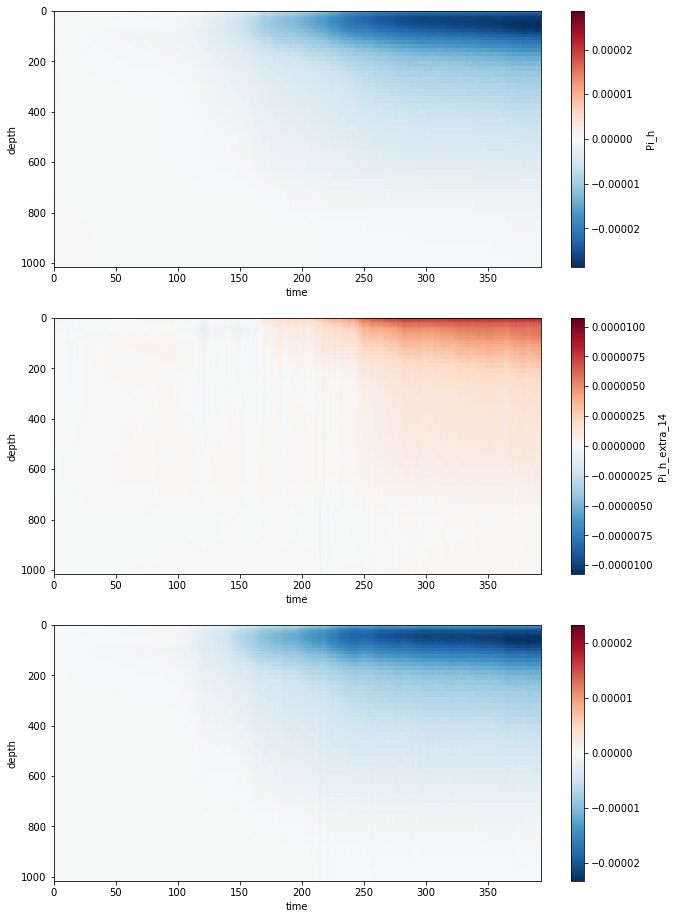

In [34]:
fig = plt.figure(figsize=(24,16))

plt.subplot(321)
Pi_h_cum.plot(x='time', y='depth',cmap='RdBu_r',yincrease=False)

plt.subplot(323)
Pi_h_extra_14_cum.plot(x='time', y='depth',cmap='RdBu_r',yincrease=False)

plt.subplot(325)
Pi_h_14_cum.plot(x='time', y='depth',cmap='RdBu_r',yincrease=False)

### A subdomain

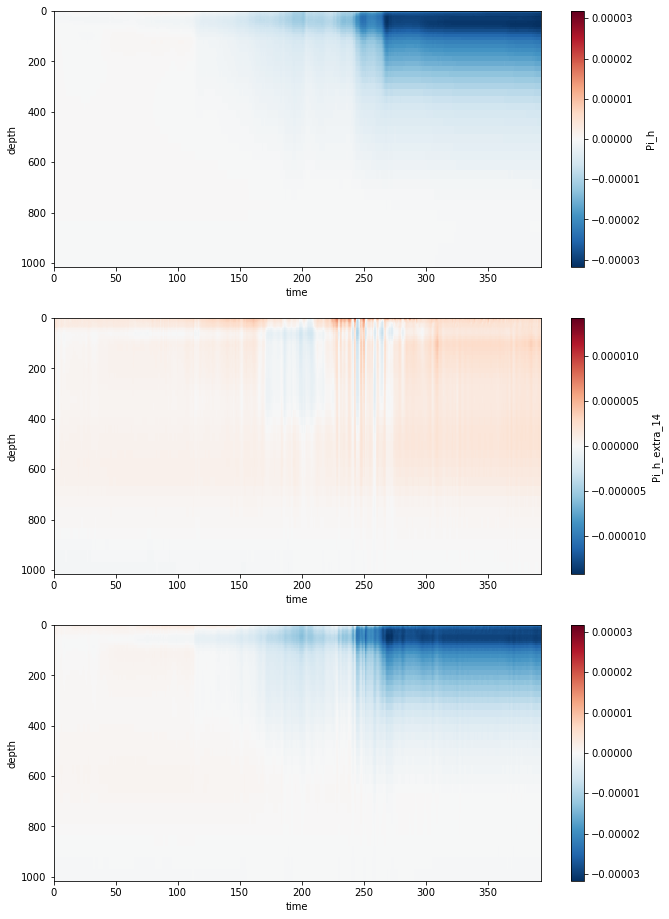

In [11]:
Pi_h_smean = Pi_h.Pi_h.isel(lat=slice(90,110),lon=slice(80,100)).mean(['lat','lon'])
Pi_h_cum = xr.DataArray.cumsum(Pi_h_smean, dim='time')

Pi_h_extra_14_smean = Pi_h_extra_14.Pi_h_extra_14.isel(lat=slice(90,110),lon=slice(80,100)).mean(['lat','lon'])
Pi_h_extra_14_cum = xr.DataArray.cumsum(Pi_h_extra_14_smean, dim='time')

Pi_h_14_smean = Pi_h_14.isel(lat=slice(90,110),lon=slice(80,100)).mean(['lat','lon'])
Pi_h_14_cum = xr.DataArray.cumsum(Pi_h_14_smean, dim='time')

fig = plt.figure(figsize=(24,16))

plt.subplot(321)
Pi_h_cum.plot(x='time', y='depth',cmap='RdBu_r',yincrease=False)

plt.subplot(323)
Pi_h_extra_14_cum.plot(x='time', y='depth',cmap='RdBu_r',yincrease=False)

plt.subplot(325)
Pi_h_14_cum.plot(x='time', y='depth',cmap='RdBu_r',yincrease=False)

## A location near to the mooring site

(-1e-08, 1e-08)

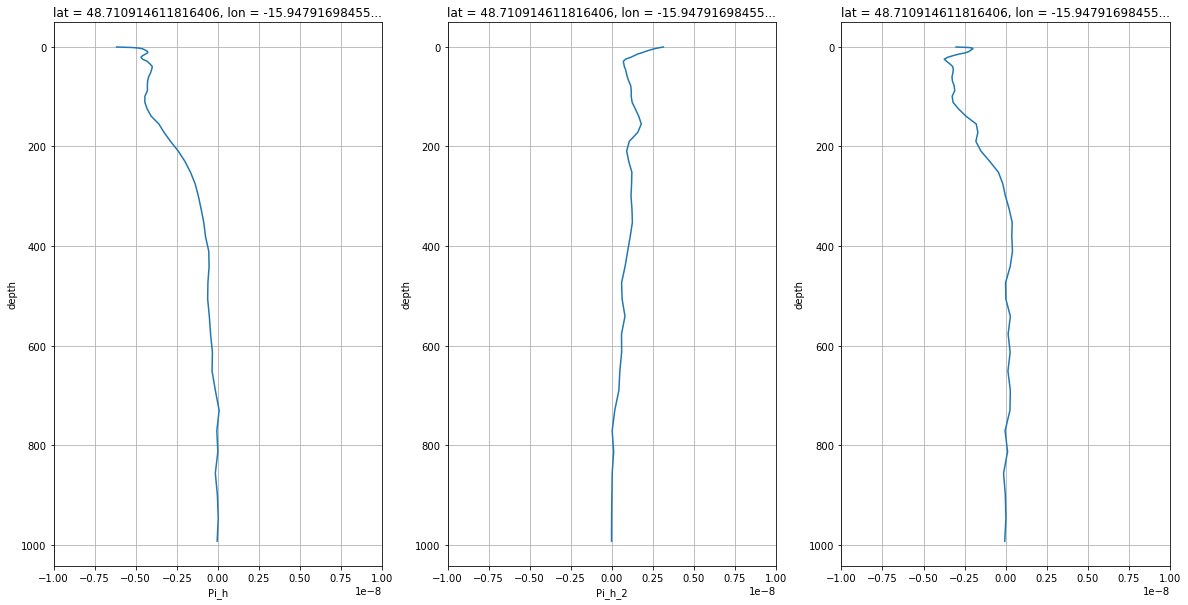

In [19]:
fig, ax = plt.subplots(figsize=(20,10))

ax = plt.subplot(131)
Pi_h.Pi_h.isel(lat=100,lon=100).mean(['time']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-1e-8,1e-8])

ax = plt.subplot(132)
Pi_h_extra_14.Pi_h_extra_14.isel(lat=100,lon=100).mean(['time']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-1e-8,1e-8])

ax = plt.subplot(133)
Pi_h_14.isel(lat=100,lon=100).mean(['time']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-1e-8,1e-8])

## the whole domain

(-3e-09, 3e-09)

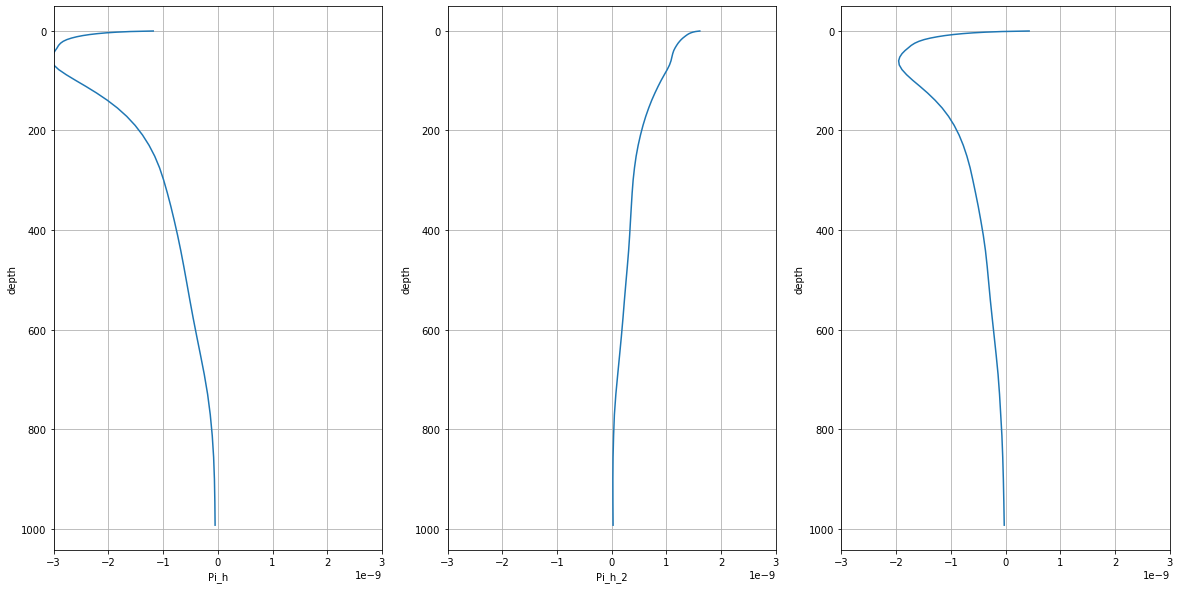

In [17]:
fig, ax = plt.subplots(figsize=(20,10))

ax = plt.subplot(131)
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time','lat','lon']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-3e-9,3e-9])

ax = plt.subplot(132)
Pi_h_extra_14.Pi_h_extra_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time','lat','lon']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-3e-9,3e-9])

ax = plt.subplot(133)
Pi_h_14.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time','lat','lon']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-3e-9,3e-9])

## figures for $\Pi_{\omega}$(11)

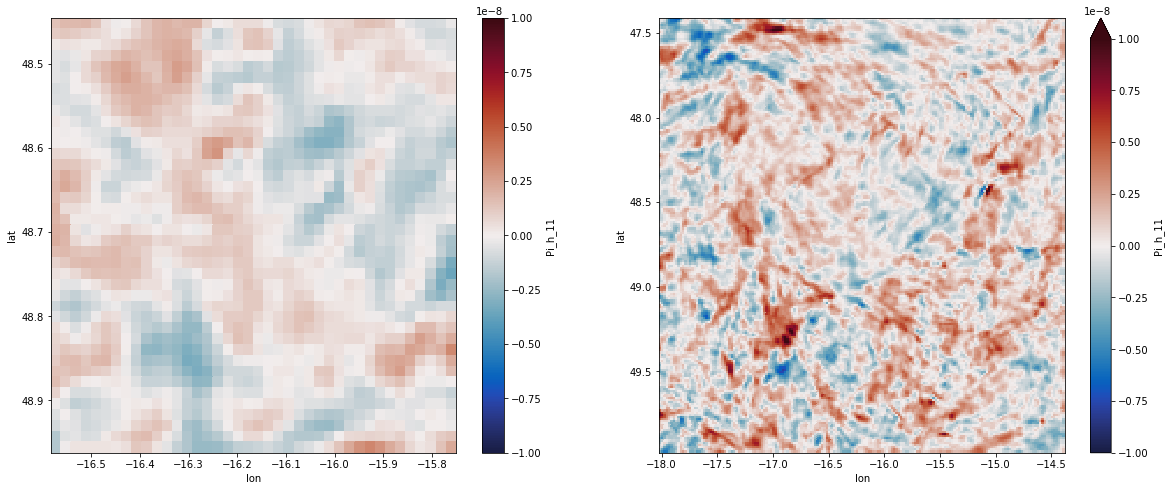

In [21]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
Pi_h_11.Pi_h_11.isel(lat=slice(80,120),lon=slice(70,110)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8,yincrease=False)
plt.subplot(122)
Pi_h_11.Pi_h_11.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8,yincrease=False)

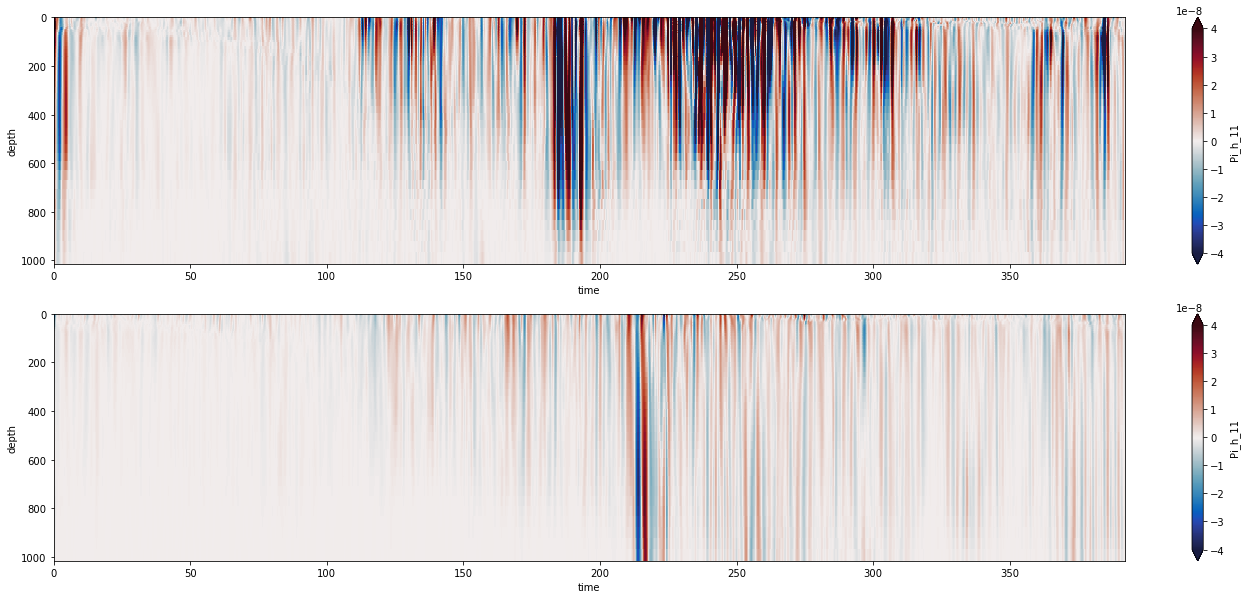

In [22]:
fig = plt.figure(figsize=(24,10))

plt.subplot(211)
Pi_h_11.Pi_h_11.isel(lat=slice(80,120),lon=slice(70,110)).mean(['lat','lon']).plot(x='time', y='depth',cmap=cm.balance, vmin=-4e-8,vmax=4e-8,yincrease=False)

plt.subplot(212)
Pi_h_11.Pi_h_11.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(x='time', y='depth',cmap=cm.balance, vmin=-4e-8,vmax=4e-8,yincrease=False)

In [25]:
Pi_h_11_smean = Pi_h_11.Pi_h_11.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
Pi_h_11_cum = xr.DataArray.cumsum(Pi_h_11_smean, dim='time')

<xarray.DataArray 'Pi_h_11' (time: 9415, depth: 52)>
dask.array<mean_agg-aggregate, shape=(9415, 52), dtype=float32, chunksize=(9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

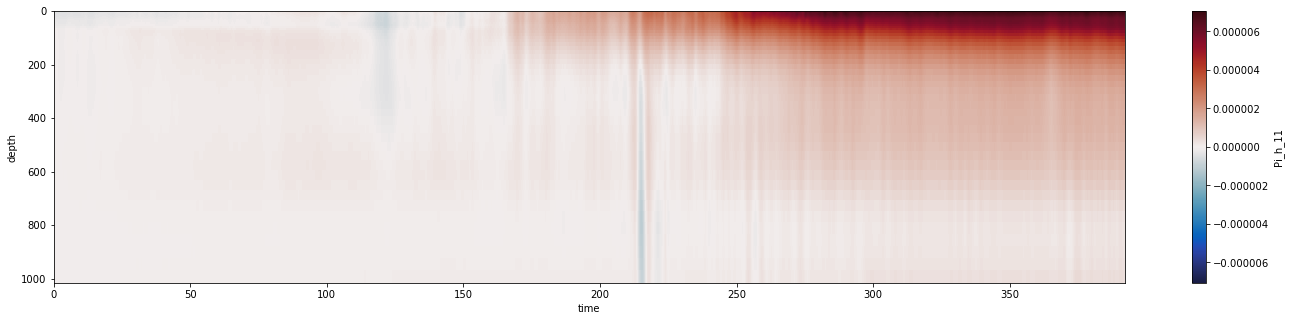

In [28]:
fig = plt.figure(figsize=(24,5))
Pi_h_11_cum.plot(x='time', y='depth',cmap=cm.balance,yincrease=False)

(-3e-09, 3e-09)

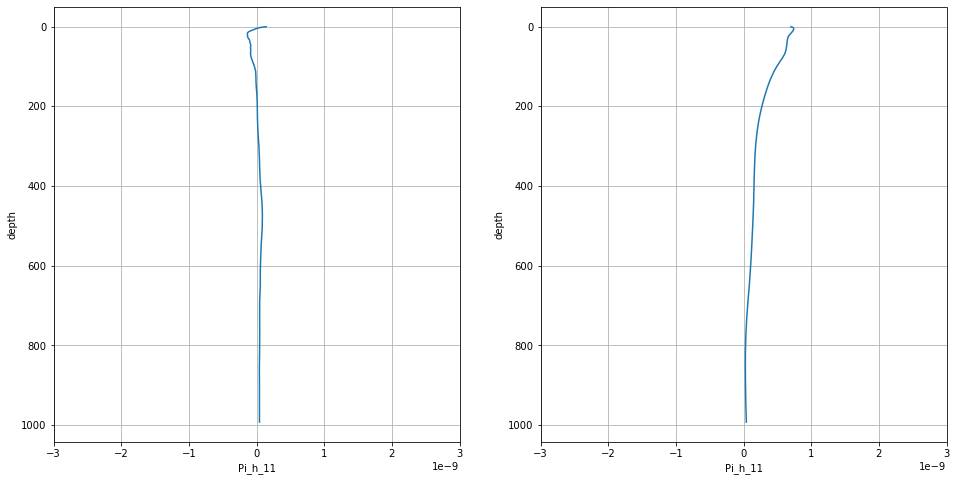

In [18]:
fig, ax = plt.subplots(figsize=(16,8))

ax = plt.subplot(121)
Pi_h_11.Pi_h_11.isel(lat=slice(80,120),lon=slice(70,110)).mean(['time','lat','lon']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-3e-9,3e-9])

ax = plt.subplot(122)
Pi_h_11.Pi_h_11.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time','lat','lon']).plot(y='depth', yincrease=False)
ax.grid()
ax.set_xlim([-3e-9,3e-9])

# 5. Some other terms

In [36]:
u_prime = gridx.interp(ds_filter.U_bandpass_filter, 'X')
v_prime = gridx.interp(ds_filter.V_bandpass_filter, 'Y')

In [51]:
KE_submesoscale = 0.5*(u_prime**2 + v_prime**2)
KE_submesoscale

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [52]:
KE_mesoscale = 0.5*(gridx.interp(ds_filter['U_low_filter']**2,'X') + gridx.interp(ds_filter['V_low_filter']**2,'Y'))
KE_mesoscale

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [53]:
dKEs_dt = (KE_submesoscale.shift(time=-1) - KE_submesoscale.shift(time=1) )/2/3600
dKEm_dt = (KE_mesoscale.shift(time=-1) - KE_mesoscale.shift(time=1) )/2/3600

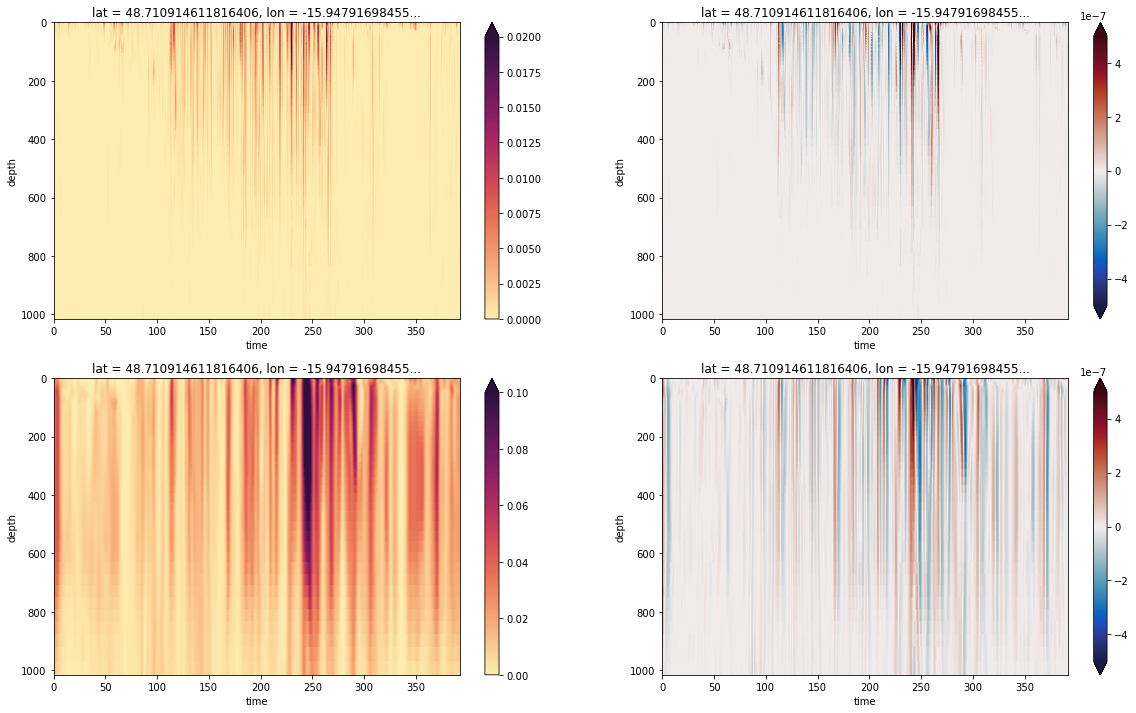

In [63]:
fig = plt.figure(figsize=(20,12))

plt.subplot(221)
KE_submesoscale.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.matter, vmin=0,vmax=0.02,yincrease=False)
plt.subplot(223)
KE_mesoscale.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.matter, vmin=0,vmax=0.1,yincrease=False)

plt.subplot(222)
dKEs_dt.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.balance,vmin=-5e-7,vmax=5e-7,yincrease=False)
plt.subplot(224)
dKEm_dt.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.balance,vmin=-5e-7,vmax=5e-7,yincrease=False)

In [9]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1